### Imports and data loading

In [1]:
from constants import *
from data_loading import *
from data_cleaning import *
from utils import *
from embeddings import *
from prediction import *
import matplotlib.pyplot as plt
import itertools

#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)


# load training set as DataFrame
train = load_df(TRAIN_NEG, TRAIN_POS, TWEET, LABEL, LABEL_NEG, LABEL_POS)
test = pd.DataFrame({TWEET: load_txt(TEST_DATA)})
# set patterns to remove, replace, and replace with
to_remove = "<user>"
to_replace = "[^a-zA-Z#]"
replace_value = " "
# clean training set
#train = clean(train, TWEET, CLEAN_TWEET, to_remove, to_replace, replace_value,option)

### General functions for this notebook

In [2]:
def generate_all_clean_options():
    all_clean_options = list()
    
    nb_options = 4
    bin_combinations = list(itertools.product([0,1], repeat=nb_options))
    
    for combination in bin_combinations:
        all_clean_options.append({
            'duplicates': combination[0],
            'replace_pattern': combination[1],
            'stop_words': combination[2],
            'stemming': combination[3]
        })

    return all_clean_options
    
def accuracies(classifiers, train, min_df, min_features, max_features, feature_step, ngram_range):
    """ Iterates on the given parameters range and using the specified classifier, logs accuracies obtained into a
    Dataframe"""
    
    df = pd.DataFrame(columns=['method','n-gram', 'replace_pattern','stop_words','stemming','nb_features','accuracy'])
    
    all_clean_options = generate_all_clean_options()
    features_range = np.arange(min_features, max_features, step=feature_step)
    
    nb_steps = len(all_clean_options) * len(ngram_range) * len(features_range) * len(classifiers)
    step = 0
    
    for clean_options in all_clean_options:
        log_msg = '\033[1m{p:.2f}%\033[0m ({step}/{nb_step}), cleaning data with {clean_options}...'.format(
            clean_options= clean_options,
            p = 100 * (step / nb_steps),
            step = step + 1,
            nb_step = nb_steps
        )
        printOver(log_msg)
    
        train_new = clean(train, TWEET, CLEAN_TWEET, to_remove, to_replace, replace_value,clean_options)

        for classifier_str in classifiers:
            if classifier_str is "tfidf":
                classifier = classify_tfidf
            elif classifier_str is "bow":
                classifier = classify_bow
            else:
                raise Exception("Unsupported classify method: "+classifier_str)
                
            for ngram in ngram_range: 
                for nb_features in features_range:
                    log_msg = '\033[1m{p:.2f}%\033[0m ({step}/{nb_step}), classifying with {classifier}, {clean_options}...'.format(
                        classifier = classifier_str,
                        clean_options= clean_options,
                        p = 100 * (step / nb_steps),
                        step = step + 1,
                        nb_step = nb_steps
                    )
                    printOver(log_msg)

                    accuracy = classifier(train_new, None, tweets_col = CLEAN_TWEET, ngram_range=ngram, max_features =nb_features, min_df=min_df)
                    df = df.append({
                        'method': classifier_str, 
                        'n-gram': ngram[1], 
                        'duplicates': clean_options['duplicates'],
                        'replace_pattern': clean_options['replace_pattern'],
                        'stop_words': clean_options['stop_words'],
                        'stemming': clean_options['stemming'],
                        'nb_features': nb_features,
                        'accuracy': accuracy
                    }, ignore_index=True)
                    step = step + 1
                    
    log_msg = '\033[1mDone!\033[0m ({step}/{nb_step})'.format(
            p = 100 * (step / nb_steps),
            step = step,
            nb_step = nb_steps
    )
    printOver(log_msg)
    print("\n")
        
    return df

### Compute all accuracies

In [9]:
df = accuracies(
    ["bow", "tfidf"],
    train = train,
    min_df=1, 
    min_features=10000, 
    max_features=110000,
    feature_step=10000, 
    ngram_range=[(1,1), (1,2), (1,3)]
)

0.00% (1/960), classifying with bow, {'duplicates': 0, 'replace_pattern': 0, 'stop_words': 0, 'stemming': 0}...

KeyboardInterrupt: 

In [10]:
df

NameError: name 'df' is not defined

### Plotting

In [13]:
def pltdf(df, method, ngram, duplicates, replace_pattern, stop_words, stemming):
    """ Extracts all poitns varying on accuracy and nb_features that match the given settings"""
    return df.loc[ 
                (df['method'] == method) &
                (df['n-gram'] == ngram) &
                (df['duplicates'] == duplicates) &
                (df['replace_pattern'] == replace_pattern) &
                (df['stop_words'] == stop_words) &
                (df['stemming'] == stemming)
             ]

def plot_accuracies(accuracies_dfs, legends, colors, linestyles, title, axis_labels, filename):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8,6))
    
    for i, df in enumerate(accuracies_dfs):
        plt.plot(df['nb_features'], df['accuracy'],label=legends[i],color=colors[i], linestyle=linestyles[i])
        
    plt.title(title)
    plt.xlabel(axis_labels[0])
    plt.ylabel(axis_labels[1])
    plt.legend()
    
    if not os.path.exists(PLOTS_FOLDER):
        os.makedirs(PLOTS_FOLDER)
    plt.savefig(PLOTS_FOLDER + filename + '.pdf') #pdf is a better choice than png as it is vectorial
    
    plt

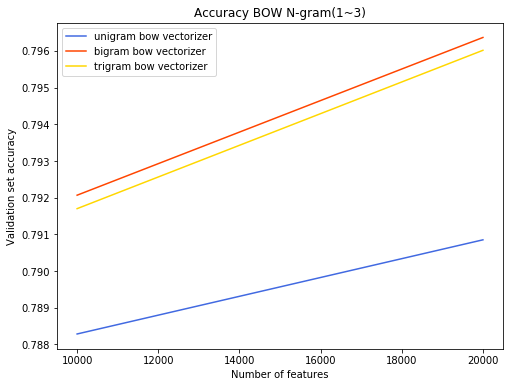

In [8]:
sub_dfs = [
    pltdf(df,"bow", 1, 0, 0, 0, 0),    
    pltdf(df,"bow", 2, 0, 0, 0, 0),
    pltdf(df,"bow", 3, 0, 0, 0, 0),
]

plot_accuracies(
    sub_dfs,
    legends = ['unigram bow vectorizer', 'bigram bow vectorizer', 'trigram bow vectorizer'],
    colors = ['royalblue', 'orangered', 'gold'],
    linestyles = ['-','-','-'],
    title = 'Accuracy BOW N-gram(1~3)',
    axis_labels =['Number of features','Validation set accuracy'],
    filename = "plot_bow"
)